In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import data using datetime and set index to datetime
df = pd.read_csv(r'D:\aa\working_results\Book3.CSV',
                                parse_dates=['Date'],
                                index_col=['Date'])

df.head()

,pm25,pm10,no2,so2,co,o3
Date,,,,,,
2017-10-17 10:00:00,110.75,234.67,82.22,101.55,1.06,27.12
2017-10-17 11:00:00,165.34,536.91,49.09,130.76,0.98,87.85
2017-10-17 12:00:00,130.91,555.58,43.34,129.64,0.53,79.69
2017-10-17 13:00:00,126.39,556.05,32.97,103.30,0.40,78.19
2017-10-17 14:00:00,131.90,504.41,42.27,94.55,0.17,72.72


In [3]:
df.tail()

,pm25,pm10,no2,so2,co,o3
Date,,,,,,
2022-12-16 08:00:00,51.14,207.80,63.70,11.43,1.00,7.86
2022-12-16 09:00:00,75.18,241.10,83.39,13.30,1.06,26.08
2022-12-16 10:00:00,62.42,219.90,64.22,14.29,0.88,43.84
2022-12-16 11:00:00,54.10,173.33,53.70,12.77,0.80,56.66
2022-12-16 12:00:00,33.23,133.40,51.72,30.68,0.89,37.06


<AxesSubplot:>

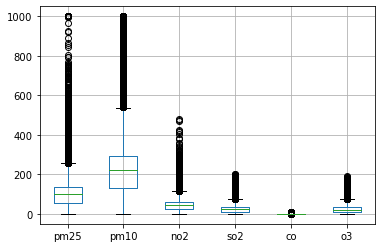

In [4]:
#Box plot
#pd.options.display.mpl_style = False
df.boxplot()

In [5]:
dataset_columns = df.columns.tolist()
dataset_columns

['pm25', 'pm10', 'no2', 'so2', 'co', 'o3']

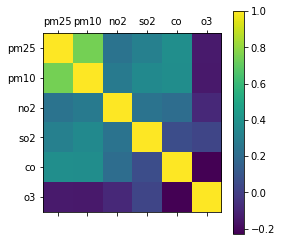

In [6]:
#Analysing relationship between different features
# cor_cols = ['pollution', 'wnd_spd', 'rain', 'snow', 'temp']
cor_cols = dataset_columns
plt.matshow(df.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()


In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = df.values
encoder = LabelEncoder()
values[:,11] = encoder.fit_transform(values[:,11])
values = values.astype('float32')
values[:,11]

IndexError: index 11 is out of bounds for axis 1 with size 6

In [8]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [9]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [10]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (45263, 1)
X (45263, 4, 6)


In [11]:
#Splitting the dataset 365*.2=73 and 365-73=292
n_train = 110
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (45153, 4, 6)
X_test (110, 4, 6)
Y_train (45153, 1)
Y_test (110, 1)


In [12]:

#Importing LSTM model
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
import tensorflow as tf
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

#model.compile(optimizer = 'adam', loss = 'mean_squared_error')     
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt)

In [13]:
history = model.fit(X_train, Y_train, epochs=5,
                    batch_size=32, validation_data=(X_test,Y_test),
                    verbose=2, shuffle=False)

Epoch 1/5
1412/1412 - 16s - loss: 0.0794 - val_loss: 0.0496 - 16s/epoch - 11ms/step
Epoch 2/5
1412/1412 - 11s - loss: 0.0128 - val_loss: 0.1161 - 11s/epoch - 8ms/step
Epoch 3/5
1412/1412 - 11s - loss: 0.0124 - val_loss: 0.0888 - 11s/epoch - 8ms/step
Epoch 4/5
1412/1412 - 11s - loss: 0.0126 - val_loss: 0.0595 - 11s/epoch - 8ms/step
Epoch 5/5
1412/1412 - 11s - loss: 0.0110 - val_loss: 0.0701 - 11s/epoch - 8ms/step


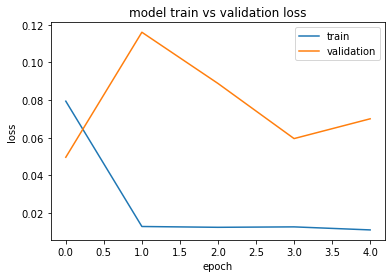

In [14]:
# plot train and validation loss
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [15]:
#Taking predictions
from keras.models import load_model
model.save('AirPollutionMultivariate.h5')

In [16]:
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)
print(mse)

rmse = np.sqrt(mse)
print(rmse)

4/4 [==============================] - 1s 6ms/step
0.0700546477942742
0.2646783855819628


In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(Y_test, Y_pred)
print('MAPE', mape)

MAPE 85.10620177388579


In [18]:
def call(c):
    history = model.fit(X_train, Y_train, epochs=c,
                    batch_size=32, validation_data=(X_test,Y_test),
                    verbose=2, shuffle=False)
        # plot train and validation loss
    from matplotlib import pyplot
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()
    Y_pred = model.predict(X_test)

    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(Y_test, Y_pred)
    print(mse)

    rmse = np.sqrt(mse)
    print(rmse)
    
    #fn
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(Y_test, Y_pred)
    print('MAPE', mape)

Epoch 1/50
1412/1412 - 11s - loss: 0.0104 - val_loss: 0.0706 - 11s/epoch - 8ms/step
Epoch 2/50
1412/1412 - 12s - loss: 0.0105 - val_loss: 0.0713 - 12s/epoch - 9ms/step
Epoch 3/50
1412/1412 - 13s - loss: 0.0109 - val_loss: 0.0740 - 13s/epoch - 9ms/step
Epoch 4/50
1412/1412 - 11s - loss: 0.0104 - val_loss: 0.0697 - 11s/epoch - 8ms/step
Epoch 5/50
1412/1412 - 11s - loss: 0.0106 - val_loss: 0.0747 - 11s/epoch - 8ms/step
Epoch 6/50
1412/1412 - 11s - loss: 0.0105 - val_loss: 0.0708 - 11s/epoch - 8ms/step
Epoch 7/50
1412/1412 - 11s - loss: 0.0106 - val_loss: 0.0695 - 11s/epoch - 8ms/step
Epoch 8/50
1412/1412 - 11s - loss: 0.0106 - val_loss: 0.0697 - 11s/epoch - 8ms/step
Epoch 9/50
1412/1412 - 11s - loss: 0.0109 - val_loss: 0.0703 - 11s/epoch - 8ms/step
Epoch 10/50
1412/1412 - 12s - loss: 0.0109 - val_loss: 0.0749 - 12s/epoch - 9ms/step
Epoch 11/50
1412/1412 - 13s - loss: 0.0106 - val_loss: 0.0713 - 13s/epoch - 9ms/step
Epoch 12/50
1412/1412 - 12s - loss: 0.0104 - val_loss: 0.0702 - 12s/epoch 

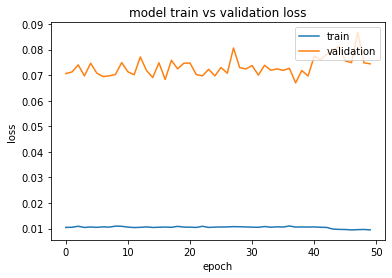

4/4 [==============================] - 0s 4ms/step
0.07444307067058378
0.27284257488629554
MAPE 89.51544873686838
Epoch 1/100
1412/1412 - 14s - loss: 0.0096 - val_loss: 0.0766 - 14s/epoch - 10ms/step
Epoch 2/100
1412/1412 - 14s - loss: 0.0095 - val_loss: 0.0744 - 14s/epoch - 10ms/step
Epoch 3/100
1412/1412 - 14s - loss: 0.0097 - val_loss: 0.0790 - 14s/epoch - 10ms/step
Epoch 4/100
1412/1412 - 14s - loss: 0.0098 - val_loss: 0.0807 - 14s/epoch - 10ms/step
Epoch 5/100
1412/1412 - 14s - loss: 0.0096 - val_loss: 0.0804 - 14s/epoch - 10ms/step
Epoch 6/100
1412/1412 - 14s - loss: 0.0096 - val_loss: 0.0796 - 14s/epoch - 10ms/step
Epoch 7/100
1412/1412 - 14s - loss: 0.0098 - val_loss: 0.0757 - 14s/epoch - 10ms/step
Epoch 8/100
1412/1412 - 14s - loss: 0.0095 - val_loss: 0.0756 - 14s/epoch - 10ms/step
Epoch 9/100
1412/1412 - 14s - loss: 0.0097 - val_loss: 0.0743 - 14s/epoch - 10ms/step
Epoch 10/100
1412/1412 - 14s - loss: 0.0095 - val_loss: 0.0843 - 14s/epoch - 10ms/step
Epoch 11/100
1412/1412 - 

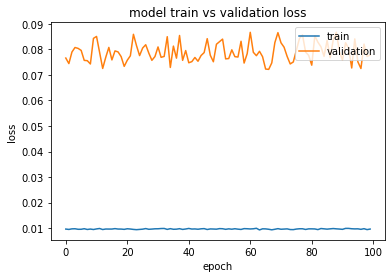

4/4 [==============================] - 0s 5ms/step
0.07782988404635059
0.27898007822486287
MAPE 92.76761829621495
Epoch 1/150
1412/1412 - 14s - loss: 0.0099 - val_loss: 0.0801 - 14s/epoch - 10ms/step
Epoch 2/150
1412/1412 - 14s - loss: 0.0096 - val_loss: 0.0849 - 14s/epoch - 10ms/step
Epoch 3/150
1412/1412 - 14s - loss: 0.0097 - val_loss: 0.0785 - 14s/epoch - 10ms/step
Epoch 4/150
1412/1412 - 14s - loss: 0.0097 - val_loss: 0.0761 - 14s/epoch - 10ms/step
Epoch 5/150
1412/1412 - 14s - loss: 0.0097 - val_loss: 0.0808 - 14s/epoch - 10ms/step
Epoch 6/150
1412/1412 - 14s - loss: 0.0097 - val_loss: 0.0749 - 14s/epoch - 10ms/step
Epoch 7/150
1412/1412 - 14s - loss: 0.0095 - val_loss: 0.0784 - 14s/epoch - 10ms/step
Epoch 8/150
1412/1412 - 14s - loss: 0.0096 - val_loss: 0.0794 - 14s/epoch - 10ms/step
Epoch 9/150
1412/1412 - 14s - loss: 0.0097 - val_loss: 0.0788 - 14s/epoch - 10ms/step
Epoch 10/150
1412/1412 - 14s - loss: 0.0096 - val_loss: 0.0758 - 14s/epoch - 10ms/step
Epoch 11/150
1412/1412 - 

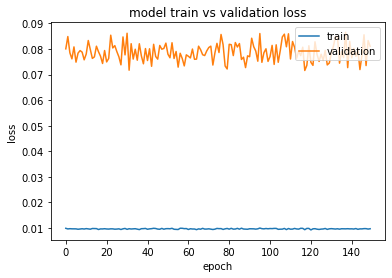

4/4 [==============================] - 0s 5ms/step
0.0810358318378053
0.2846679325772492
MAPE 95.73919708336257
Epoch 1/200
1412/1412 - 10s - loss: 0.0096 - val_loss: 0.0751 - 10s/epoch - 7ms/step
Epoch 2/200
1412/1412 - 10s - loss: 0.0097 - val_loss: 0.0777 - 10s/epoch - 7ms/step
Epoch 3/200
1412/1412 - 11s - loss: 0.0096 - val_loss: 0.0781 - 11s/epoch - 7ms/step
Epoch 4/200
1412/1412 - 11s - loss: 0.0097 - val_loss: 0.0837 - 11s/epoch - 8ms/step
Epoch 5/200
1412/1412 - 11s - loss: 0.0096 - val_loss: 0.0767 - 11s/epoch - 8ms/step
Epoch 6/200
1412/1412 - 10s - loss: 0.0095 - val_loss: 0.0852 - 10s/epoch - 7ms/step
Epoch 7/200
1412/1412 - 10s - loss: 0.0097 - val_loss: 0.0733 - 10s/epoch - 7ms/step
Epoch 8/200
1412/1412 - 10s - loss: 0.0094 - val_loss: 0.0740 - 10s/epoch - 7ms/step
Epoch 9/200
1412/1412 - 11s - loss: 0.0097 - val_loss: 0.0752 - 11s/epoch - 8ms/step
Epoch 10/200
1412/1412 - 11s - loss: 0.0098 - val_loss: 0.0804 - 11s/epoch - 8ms/step
Epoch 11/200
1412/1412 - 12s - loss: 

In [ ]:
l=[50,100,150,200,250]
for i in l:
    call(i)

In [ ]:
#Scaling back to the original scale
d = scaled_dataset[:255,:]
print('dummy',d.shape)
print('Y_pred',Y_pred.shape)
Y_predicted = np.concatenate((Y_pred,d[:110,1:]), axis =1)
print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((Y_test, d[:110,1:]), axis = 1)
print('concat Y_test', Y_test.shape)

In [ ]:
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse

In [ ]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))  
plt.plot(Y_predicted[:90,:], color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_tested[:90,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(Y_tested, Y_predicted)
print('MAPE', mape)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_tested, Y_predicted)
r2

In [ ]:
# A simple plot to visualize the correlation between the columns
#df.plot(subplots=True)
df.plot(subplots=True,figsize=(15,13));


In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()